In [23]:
from oneatlas import OneAtlasClient  # custom class in this repo
import json
import geopandas as gpd
from shapely.geometry import box
from pathlib import Path

# Process overview
- Convert input aoi layer into geojson polygons
- For each aoi polygon feature:
  - Search API for available images
  - Plot the quicklook for each image found for that feature
  - Place an order for the chosen image clipped to the feature
  - Download the order once completed

In [24]:
# Read local config.json to get api key and directory for outputs
with open("config.json", "r") as file:
    config = json.load(file)

api_key = config["api_key"]

client = OneAtlasClient(api_key=api_key)

output_folder = Path(config["output_dir"])
input_file_gdb = Path(config["input_gdb"])

In [91]:
# function to convert polygon gdf to bounding box list
sites_gdf = gpd.read_file(input_file_gdb, layer="Registered_Sites_Merged")

LAYER_NAME = "Registered_Sites"  # prefix name for the clipped image downloads

In [92]:
# Drop rows with 'POINT EMPTY' geometry
empty_geom = sites_gdf[sites_gdf.geometry.is_empty]
sites_gdf = sites_gdf[~sites_gdf.geometry.is_empty]
empty_geom

,IN_Easting,IN_Northing,USER_Name_of_business,USER_Registered_Office_Address,USER_Address_Cont_d,USER_Address_Cont_d_1,USER_Postcode,USER_Site_Trading_Name,USER_Site_Address_1,USER_Site_Address_2,...,USER_Local_Authority,USER_Date_Added,USER_Date_removed,USER_Entity_type,USER_CRN,USER_Registered_in_Scotland,USER_Registered_in_rUK,USER_RS_Notes,USER_SIC,geometry
11,not found,not found,Aggregate Industries UK Limited,Bardon Hall,"Copt Oak Road, Markfield",None,LE67 9PJ,Clydeport,King George V Dock,Govan,...,Glasgow City Council,Jun-22,None,Limited Company,245717,No,Yes,None,"08110,08120, 23610, 42110",POINT EMPTY
12,not found,not found,Aggregate Industries UK Limited,Bardon Hall,"Copt Oak Road, Markfield",None,LE67 9PJ,Bardon Aggregates- Croy,Croy,Constarry Road,...,North Lanarkshire,Jun-22,None,Limited Company,245717,No,Yes,None,"08110,08120, 23610, 42110",POINT EMPTY
18,not found,not found,Ambrisbeg Ltd,"The Quarry, The West Road",Kingarth,None,PA20 9PE,Ambrisel Quarry,West Road,Isle Of Bute,...,Argyll and Bute,Jun-22,None,Limited Company,SC139916,Yes,No,None,"08110, 08120",POINT EMPTY
19,not found,not found,Ambrisbeg Ltd,"The Quarry, The West Road",Kingarth,None,PA20 9PE,Kingarth Sand Pit,Sand Pit,Kinlarth,...,Argyll and Bute,Jun-22,None,Limited Company,SC139916,Yes,No,None,"08110, 08120",POINT EMPTY
24,not found,not found,Angus Maciver Ltd,18 Bells Road,Stornoway,None,HS1 2RA,Angus Maciver Ltd,Lochs Road,Lochs,...,North Lanarkshire Council,Jun-22,None,Limited Company,SC055316,Yes,No,None,23910,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,not found,not found,Tarmac Trading Limited,Ground Floor T3 Trinity Park,Bickenhill Lane,None,B37 7ES,New Bigging,Carnwath,Strathclyde,...,South Lanarkshire,Jun-22,None,Limited Company,453791,No,Yes,None,"08110, 23910, 42110, 70100",POINT EMPTY
300,not found,not found,Tarmac Trading Limited,Ground Floor T3 Trinity Park,Bickenhill Lane,None,B37 7ES,Ravelrig,Kirknewton,Lothian,...,Dumfries and Galloway Council,Jun-22,None,Limited Company,453791,No,Yes,None,"08110, 23910, 42110, 70100",POINT EMPTY
301,not found,not found,Tarmac Trading Limited,Ground Floor T3 Trinity Park,Bickenhill Lane,None,B37 7ES,Snabe,Strathaven Road,Drumclog,...,South Lanarkshire,Jun-22,None,Limited Company,453791,No,Yes,None,"08110, 23910, 42110, 70100",POINT EMPTY
304,not found,not found,Tennants (Elgin) Ltd,Commerce House,South Street,None,IV30 1JE,Avochie Quarry,Hill Head Of Avochie,Huntly,...,Aberdeenshire,Jun-22,None,Limited Company,SC190066,Yes,No,None,82990,POINT EMPTY


In [93]:
def points_to_buffer_box(gdf, buffer_distance=500):
    """Buffer points by distance and convert to bounding boxes"""
    # Check if all geometries are Points
    if not all(gdf.geometry.geom_type == "Point"):
        print("All geometries in the GeoDataFrame must be Points. Exiting.")
        return None

    # Reproject to EPSG 27700
    gdf = gdf.to_crs(epsg=27700)

    # Buffer the geometries
    gdf["geometry"] = gdf.geometry.buffer(buffer_distance)

    # Convert buffers to bounding boxes
    gdf["geometry"] = gdf.geometry.apply(lambda geom: box(*geom.bounds))

    return gdf

In [94]:
sites_box_gdf = points_to_buffer_box(sites_gdf)

In [95]:
def aoi_gdf_to_search_geojson(gdf, uid_column=None):
    """Convert geodataframe to geojson ensuring unique ids per feature"""

    if uid_column is None:

        uid_column = "id"

        gdf[uid_column] = gdf.index

    else:

        if not gdf[uid_column].is_unique:

            raise ValueError(
                f"Values in '{uid_column}' are not unique. Consider using default uid_column=None to add uids."
            )

    print(
        f"uid_column '{uid_column}' values {', '.join(str(i) for i in gdf[uid_column].tolist())}"
    )

    json_str = gdf[[uid_column, "geometry"]].to_crs(epsg=4326).to_json(drop_id=True)

    return json.loads(json_str), gdf[uid_column].tolist()

In [96]:
# convert gdf to geojson and get the id value list to know ids to search for
search_geojson, id_vals = aoi_gdf_to_search_geojson(sites_box_gdf)

uid_column 'id' values 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20, 21, 22, 23, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 238, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 25

In [97]:
def get_feature_by_id(geojson, id_vals, search_id, uid_column="id"):
    """Filter geojson features to just one specified id"""

    if search_id not in id_vals:

        raise ValueError(f"id {search_id} not in list of id values")

    for feature in geojson["features"]:

        if feature["properties"][uid_column] == search_id:
            return feature

    return None

In [99]:
# Set the search id. Must be in the id_vals list created above.
SEARCH_ID = 1
# extract the geojson feature for that id
search_feature = get_feature_by_id(search_geojson, id_vals, SEARCH_ID)

Search options are described [here](https://www.geoapi-airbusds.com/guides/oneatlas-data/g-search/)

In [100]:
# create search json - geometry is the search feature geometry
img_search_json = {
    "cloudCover": "[0,30]",
    "incidenceAngle": "[0,40]",
    "processingLevel": "SENSOR",
    "relation": "contains",
    "geometry": search_feature["geometry"],
    "constellation": "PHR",
}

# make the request
results = client.search(img_search_json)

# extract relevant values from the results and store in client instance


client.extract_results(results)

result 1 of 1
Image ID: 3ae943e2-f207-46fb-aac2-114c31adc864
Acquisition Date: 2021-04-25T11:33:36.305Z
Constellation: PHR
Cloud Cover: 0%


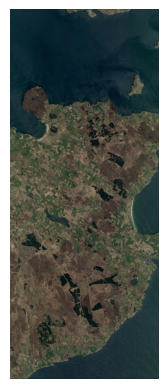

In [101]:
# Run this cell repeatedly to show each search result image quicklook in turn
client.show_result()

See the order options [here](https://www.geoapi-airbusds.com/guides/oneatlas-data/g-order-product/)

In [102]:
# create the order specification and initially just quote the price
order_body = {
    "kind": "order.data.product",
    "products": [
        {
            "productType": "multiSpectral",
            "radiometricProcessing": "REFLECTANCE",
            "imageFormat": "image/geotiff",
            "crsCode": "urn:ogc:def:crs:EPSG::4326",
            "id": client.current_image,  # current client.show_result() image
            "aoi": search_feature["geometry"],
        }
    ],
}


client.get_price(order_body)["price"]

{'credits': 2,
 'amount': 2,
 'isAmountEstimated': 'false',
 'areaKm2': 1.0,
 'amountUnit': 'EUR'}

In [ ]:
# Need to try this next order - might not work, but ideally would have a ref to identify the order
# order_body["customerRef"] = f"sg_{LAYER_NAME}_{SEARCH_ID}"

In [103]:
# Uncomment line below to place the order above (WARNING: account will be charged)
client.create_order(order_body)

{'_links': {'self': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/6408b74f-d39c-4f06-8b97-ce4c97856084'},
  'cancel': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/6408b74f-d39c-4f06-8b97-ce4c97856084/cancel'},
  'contract': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/contracts/e718a202-0fee-44b3-ab83-18d7d7bdaff4'},
  'payments': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/6408b74f-d39c-4f06-8b97-ce4c97856084/payments'},
  'deliveries': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/6408b74f-d39c-4f06-8b97-ce4c97856084/deliveries'},
  'subscription': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/subscriptions/fc61e236-374a-4314-9615-dbc303a81b0b'}},
 'id': '6408b74f-d39c-4f06-8b97-ce4c97856084',
 'kind': 'order.data.product',
 'service': 'data',
 'createdAt': '2024-02-23T14:57:49Z',
 'updatedAt': '2024-02-23T14:57:50Z',
 'createdBy': 'c9c09c00-099a-4cdb-7227-f59b674d0ff6',
 'status': 'ordered',
 'contractId

In [104]:
# See current and previous orders - select which want
orders = client.list_orders(kind="order.data.product", status="delivered")
orders

{'startIndex': 0,
 'totalResults': 258,
 'countLimitReached': False,
 'itemsPerPage': 10,
 'items': [{'_links': {'self': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/70020c8d-86d0-4a70-91fe-11aa7735e81f'},
    'cancel': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/70020c8d-86d0-4a70-91fe-11aa7735e81f/cancel'},
    'contract': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/contracts/e718a202-0fee-44b3-ab83-18d7d7bdaff4'},
    'payments': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/70020c8d-86d0-4a70-91fe-11aa7735e81f/payments'},
    'deliveries': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/orders/70020c8d-86d0-4a70-91fe-11aa7735e81f/deliveries'},
    'subscription': {'href': 'https://data.api.oneatlas.airbus.com/api/v1/subscriptions/fc61e236-374a-4314-9615-dbc303a81b0b'}},
   'id': '70020c8d-86d0-4a70-91fe-11aa7735e81f',
   'kind': 'order.data.product',
   'service': 'data',
   'createdAt': '2024-02-23T14:49:51Z',
   'upd

In [105]:
ORDER_INDEX = 0  # Set as required. 0-indexed item number from the orders list
order = orders["items"][ORDER_INDEX]

# The config.json in the repo specifies the output_folder
output_file = output_folder / f"{LAYER_NAME}_{SEARCH_ID}.zip"

# Download the order to specified zip file
client.download_order_to_file(order, output_file)